In [137]:
import numpy as np
import math
import tensorflow as tf
 
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from keras.datasets import fashion_mnist

In [138]:
def plot_confusion_mtx(matrix,num_classes):

  plt.figure(figsize=(10,8))
  ax= plt.subplot()
  cmap=sns.light_palette("blue")
  sns.heatmap(matrix, annot=True, ax = ax,fmt=".3f"); 
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels');
  ax.set_title('Confusion Matrix For Test Data');
  ax.xaxis.set_ticklabels([str(i) for i in range(num_classes)]); ax.yaxis.set_ticklabels([str(i) for i in range(num_classes)]);
  plt.show()

In [139]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
labels=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

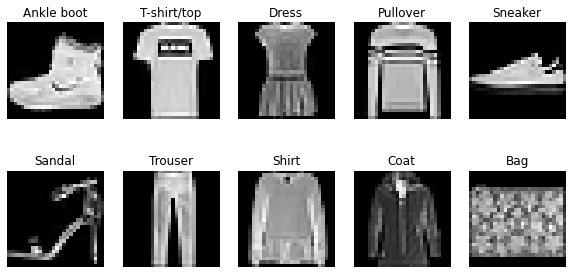

In [140]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5)) 

plottedClass =  [False for i in range(10)] 
count=0
for i in range(25):
    if  plottedClass[Y_train[i]]==False:
      plt.subplot(2,5,count+1).set_title(labels[Y_train[i]]) 
      plt.imshow(X_train[i],cmap='gray')
      plt.axis("off")
      plottedClass[Y_train[i]]=True
      count=count+1

plt.show()

**Backpropagation code stage1.**

In [141]:
#flatten the Xtrain and X_test
X_train=X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test=X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

#create one hot encoding of the labels
Y_train_ohe=OneHotEncoder().fit_transform(Y_train.reshape(-1,1)).toarray()
Y_test_ohe=OneHotEncoder().fit_transform(Y_test.reshape(-1,1)).toarray()


#normalizing the train data and test data...
X_train = X_train/255
X_test = X_test/255

In [142]:
class Activation:

  def Sigmoid(self,x):
    return 1/(1+np.exp(-x))

  def Softmax(self,x):
    mx = np.max(x,axis=1).reshape(-1,1)
    num = np.exp(x-mx)
    denom = np.sum(num,axis = 1).reshape(-1,1)
    return num/denom

  def Relu(self,x):
    return np.maximum(0, x)

  def Tanh(self,x):
    numr = np.exp(x) - np.exp(-x)
    denom=np.exp(x) + np.exp(-x)
    return numr/denom

  def Derivative_Sigmoid(self,x):
    s=1/(1 + np.exp(-x))
    return s*(1-s)

  def Derivative_Relu(self,x):
    return x>=0

  def Derivative_Tanh(self,x):
    return 1-self.Tanh(x)**2


In [143]:
#Returns the average Loss..
class Loss:
  def CategoricalCrossEntropy(self,ypred,y):
    class_idx = np.argmax(y,axis=1)
    cce_loss = 0
    for i in range(len(class_idx)):
      cce_loss+=(-1)*np.log2(ypred[i] [class_idx[i]])
    return cce_loss/len(ypred)
  
  def MSE(self,ypred,y):
    return np.sum((ypred - y)**2)/len(ypred)

In [144]:
class IpLayer:

  def __init__(self,num_neurons):
    self.num_neurons=num_neurons
    self.hL=0

  def Forward(self,x):
    self.hL=x

In [145]:
class Layer:

  def __init__(self,num_inputs,num_neurons,activation,loss,optimizer,layerInitialization):
    
    self.num_inputs=num_inputs ;self.num_neurons=num_neurons ;self.activation=activation ;self.optimizer=optimizer ;self.loss=loss
    self.aL=0 ; self.hL=0 ; self.del_h=0 ;self.del_a=0 ;self.delW=0 ;self.delb=0 ;self.prev_Uw=0 ;self.prev_Ub=0
    self.prev_Vw=0 ;self.prev_Vb=0 ;self.prev_Mw=0 ;self.prev_Mb=0

    if layerInitialization=="random":
      self.W=np.random.randn(self.num_neurons,self.num_inputs) ;self.b=np.random.randn(self.num_neurons,)
    elif layerInitialization=="Xavier":
      initializer = tf.keras.initializers.GlorotNormal() ;self.W=initializer((self.num_neurons,self.num_inputs)).numpy() ;self.b=initializer((self.num_neurons,)).numpy()
    
  #Given input from the previous layer as h_L_1 get the preactivation(aL) and postactivation(hL)..  
  def Forward(self,h_L_1):
    self.aL = np.dot(h_L_1,(self.W).T)+self.b

    if self.activation=='ReLU':
      self.hL = Activation().Relu(self.aL)
    elif self.activation=='tanh':
      self.hL = Activation().Tanh(self.aL)
    elif self.activation=='Softmax':
      self.hL = Activation().Softmax(self.aL)
    elif self.activation == 'sigmoid':
      self.hL = Activation().Sigmoid(self.aL)
    else:
      raise Exception("choose a valid activation")
    
    return

  #Given Y_hat and Y calculate the gradients for diff Layers..
  def get_gradients(self,isoplayer,Y_hat,Y,prev_hL,nextW,next_del_a):

      #If it is the output layer...
      if isoplayer == 1:
        if self.loss=='cce':
          self.del_a = Y_hat-Y
        
        elif self.loss == 'squarederror':
          bs = len(Y)
          num_cls = len(Y[0])
          DelA=[]
          for j in range(bs):
            del_aj=[]
            init = 2*(Y_hat[j] - Y[j])*(Y_hat[j])
            for i in range(num_cls):
              ohe_i = np.zeros(num_cls,)
              ohe_i[i] = 1
              pd_aji=ohe_i - Y_hat[j][i]
              pd_aji *= init
              del_aj.append(np.sum(pd_aji,axis=0))
            DelA.append(del_aj)

          self.del_a = np.array(DelA)
        else:
          raise Exception("!!!  ")

      #if it is not the output layer..
      else:
        self.del_h = np.dot(next_del_a , nextW)
        if self.activation=='ReLU':
          self.del_a=(self.del_h)*(Activation().Derivative_Relu(self.aL))
        elif self.activation=='tanh':
          self.del_a=(self.del_h)*(Activation().Derivative_Tanh(self.aL))
        elif self.activation == 'sigmoid':
          self.del_a=(self.del_h)*(Activation().Derivative_Sigmoid(self.aL))

      self.delW = np.dot(self.del_a.T,prev_hL)/len(Y)
      self.delb = np.sum(self.del_a,axis=0)/len(Y)
      return

In [146]:
class NN:

  def __init__(self,input_shape,num_hlayers,neurons,hiddenLayerActivation,outputActivation,loss,optimizer,learningrate,batch_size,epochs,layerInitialization,weightDecay,output_shape):

    self.input_shape=input_shape ;self.output_shape=output_shape ;self.num_hlayers=num_hlayers ;self.neurons=neurons ;self.HLAc=hiddenLayerActivation
    self.OPAc=outputActivation ;self.optimizer=optimizer ;self.batch_size=batch_size ;self.epochs=epochs ; self.layer_init=layerInitialization
    self.Layers=[] ;self.eta=learningrate ;self.weightDecay=weightDecay ;self.learningrate=learningrate
    self.gamma=0.9 ;self.beta=0.8 ;self.epsilon=1e-5 ; self.beta1=0.9 ;self.beta2=0.999 ;self.Y_hat=0 ; self.loss=loss
    
    #store the Layers in self.Layers[]..

    self.Layers.append(IpLayer(self.input_shape))
    #hidden layers..
    for layer in range(1,self.num_hlayers+2):
      ip_shape=self.Layers[layer-1].num_neurons
      #output layer...
      if layer==self.num_hlayers+1:
         self.Layers.append(Layer(ip_shape,self.output_shape,self.OPAc,self.loss,self.optimizer,layerInitialization))
      else:
        self.Layers.append(Layer(ip_shape,self.neurons[layer-1],self.HLAc,self.loss,self.optimizer,layerInitialization))

  #given a batch X feed it forward in the network to get Y_hat..
  def Feed_Forward(self,X):
    self.Y_hat=[]
    if self.optimizer=='nesterov' or self.optimizer=='nadam':
      #Go to lookaheads(Wla,bla) and get the loss there..
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].W = self.Layers[i].W - self.gamma * self.Layers[i].prev_Uw
        self.Layers[i].b = self.Layers[i].b - self.gamma * self.Layers[i].prev_Ub

    #get the data in input layer...
    self.Layers[0].Forward(X)
    for j in range(1,self.num_hlayers+2):
      h_L_1=self.Layers[j-1].hL
      self.Layers[j].Forward(h_L_1)
    self.Y_hat = self.Layers[self.num_hlayers+1].hL
    return
  
  #get gradients for each layer...
  def Back_Propogation(self,Y):
    for i in range(self.num_hlayers+1,0,-1):
      prev_hL = self.Layers[i-1].hL
      if i == self.num_hlayers+1:
        self.Layers[i].get_gradients(1,self.Y_hat,Y,prev_hL,0,0)
      else:
        next_W = self.Layers[i+1].W
        next_del_a = self.Layers[i+1].del_a
        self.Layers[i].get_gradients(0,self.Y_hat,Y,prev_hL,next_W,next_del_a)
    return

  #Update W,b for each layer w.r.t. the optimizer used...
  def Update_Params(self,iteration):

    for i in range(1,self.num_hlayers+2):
      if self.optimizer == 'sgd':
        self.Layers[i].W = (1-self.weightDecay*(self.eta))*self.Layers[i].W - (self.eta)*(self.Layers[i].delW)
        self.Layers[i].b = (1-self.weightDecay*(self.eta))*self.Layers[i].b - (self.eta)*(self.Layers[i].delb)
      elif self.optimizer == 'momentum' or self.optimizer == 'nesterov':
        #get momentum..
        Uw_t = (self.gamma) * (self.Layers[i].prev_Uw) + (self.eta) * (self.Layers[i].delW)
        Ub_t = self.gamma * self.Layers[i].prev_Ub + (self.eta) * (self.Layers[i].delb)
        #update the parameters..
        self.Layers[i].W = (1-self.weightDecay*(self.eta))*self.Layers[i].W - Uw_t
        self.Layers[i].b = (1-self.weightDecay*(self.eta))*self.Layers[i].b - Ub_t
        #update the moments..
        self.Layers[i].prev_Uw = Uw_t
        self.Layers[i].prev_Ub = Ub_t

      elif self.optimizer == 'rmsprop':
        #get vt's and update history..
        self.Layers[i].prev_Vw = (self.beta)*(self.Layers[i].prev_Vw) + (1-self.beta)*(self.Layers[i].delW)**2   
        self.Layers[i].prev_Vb = (self.beta)*(self.Layers[i].prev_Vb) + (1-self.beta)*(self.Layers[i].delb)**2.   
        #update the parameters..
        self.Layers[i].W = (1-self.weightDecay*(self.eta))*self.Layers[i].W - (self.eta)*((self.Layers[i].delW)/np.sqrt(self.Layers[i].prev_Vw+self.epsilon)) 
        self.Layers[i].b = (1-self.weightDecay*(self.eta))*self.Layers[i].b - (self.eta)*((self.Layers[i].delb)/np.sqrt(self.Layers[i].prev_Vb+self.epsilon)) 

      elif self.optimizer == 'adam' or self.optimizer == 'nadam':
        #update previous history..
        self.Layers[i].prev_Mw = self.beta1 * self.Layers[i].prev_Mw + (1-self.beta1) * (self.Layers[i].delW)
        self.Layers[i].prev_Mb = self.beta1 * self.Layers[i].prev_Mb + (1-self.beta1) * (self.Layers[i].delb)
        #2>> Get the learning rate update: Vw=beta2*(V_w[t-1])+(1-beta2)*(delW)**2
        self.Layers[i].prev_Vw = self.beta2 * self.Layers[i].prev_Vw + (1-self.beta2) * (self.Layers[i].delW)**2
        self.Layers[i].prev_Vb = self.beta2 * self.Layers[i].prev_Vb + (1-self.beta2) * (self.Layers[i].delb)**2
        #3>> Get m^W,V^W and m^b and V^b
        m_w_hat = self.Layers[i].prev_Mw/(1 - math.pow(self.beta1,iteration+1))
        m_b_hat = self.Layers[i].prev_Mb/(1 - math.pow(self.beta1,iteration+1))
        v_w_hat = self.Layers[i].prev_Vw/(1 - math.pow(self.beta2,iteration+1))
        v_b_hat = self.Layers[i].prev_Vb/(1 - math.pow(self.beta2,iteration+1))
        #4>> update W ,b for each layer..
        self.Layers[i].W = (1-self.weightDecay*(self.eta))*self.Layers[i].W - (self.eta)*(m_w_hat/np.sqrt(v_w_hat+self.epsilon))
        self.Layers[i].b = (1-self.weightDecay*(self.eta))*self.Layers[i].b - (self.eta)*(m_b_hat/np.sqrt(v_b_hat+self.epsilon))
      else:
        raise Exception("Invalid optimizer!!!!!")
    
    return

  #Given X get the probability output for X..
  def Final_Prediction(self,X):
    pred_whole=[]
    self.Layers[0].Forward(X)
    for j in range(1,self.num_hlayers+2):
      h_L_1=self.Layers[j-1].hL
      self.Layers[j].Forward(h_L_1)
    
    return  self.Layers[self.num_hlayers+1].hL
 

**Training..**

In [147]:
X_actualTrain,X_validationData,Y_actualTrain,Y_validationData=train_test_split(X_train,Y_train_ohe,test_size=0.2,stratify=Y_train_ohe)

In [148]:
def MINI_BATCH(NN,X,Y):
  loss_epoch=[]
  n=X.shape[0]
  for i in range(NN.epochs):
    itr=0
    sidx = 0
    #pass data by batches and update the W,b..
    while sidx+NN.batch_size <= n:
      NN.Feed_Forward(X[sidx : sidx+NN.batch_size])
      NN.Back_Propogation(Y[sidx : sidx+NN.batch_size])
      NN.Update_Params(itr)
      itr+=1
      sidx+=NN.batch_size
      
    #pass the remining data.
    if sidx!=n:
      NN.Feed_Forward(X[sidx : n])
      NN.Back_Propogation(Y[sidx : n])
      NN.Update_Params(itr)
      NN.Reset_Gradients()

  return NN.Final_Prediction(X)

****Comparison between squarederror and crossentropy as loss function on the best model obtained****

FOR  cce
train accuracy :  0.9064791666666666
train loss :  0.1351917338037826
cv accuracy :  0.8693333333333333
cv loss :  0.19101845581987917
TEST accuracy :  0.8621
Confusion matrix for test :


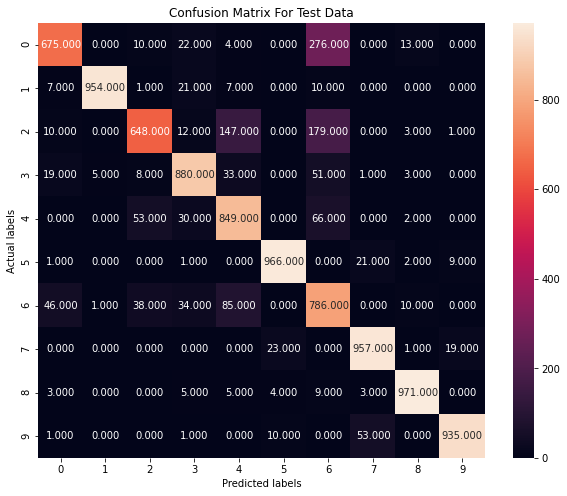

FOR  squarederror
train accuracy :  0.9087291666666667
train loss :  0.13775996613314054
cv accuracy :  0.8765
cv loss :  0.18427553859254625
TEST accuracy :  0.8644
Confusion matrix for test :


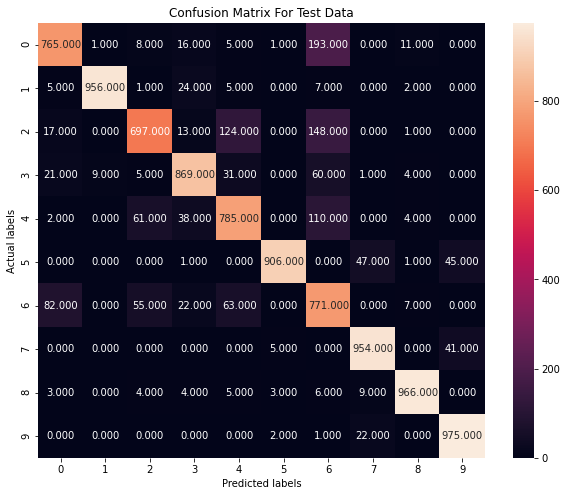

In [136]:
for loss in ['cce','squarederror']:
  NN1 = NN(input_shape=784,num_hlayers=2,neurons=[64,64],hiddenLayerActivation='ReLU',outputActivation='Softmax',loss=loss,optimizer='nadam',\
            learningrate=0.001,batch_size=16,epochs=20,layerInitialization='Xavier',weightDecay=0,output_shape=10)

  print("FOR ",loss)
  pred =MINI_BATCH(NN1,X_actualTrain,Y_actualTrain)
  print("train accuracy : ",np.sum(np.argmax(pred,axis=1)==np.argmax(Y_actualTrain,axis=1))/len(Y_actualTrain))
  print("train loss : ",np.sum(Loss().MSE(ypred=pred,y=Y_actualTrain)))

  predcv = NN1.Final_Prediction(X_validationData)
  print("cv accuracy : ",np.sum(np.argmax(predcv,axis=1)==np.argmax(Y_validationData,axis=1))/len(Y_validationData))
  print("cv loss : ",np.sum(Loss().MSE(ypred=predcv,y=Y_validationData)))

  predtest =NN1.Final_Prediction(X_test)
  print("TEST accuracy : ",np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test_ohe))
  print("Confusion matrix for test :")
  cf = confusion_matrix(y_true = np.argmax(Y_test_ohe,axis=1),y_pred = np.argmax(predtest , axis=1))
  plot_confusion_mtx(cf,10)

In [54]:
!pip install wandb -qqq
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [63]:
sweep_config = {
  "name": "Linear_activation_sweep",
  "method": "bayes",
  "metric": {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
  "parameters": {
        "optimizer": {
            "values": ['sgd','momentum','nesterov','rmsprop','adam','nadam']
        },
        "noOfNeurons":{
            "values":[32, 64 ,128]
        },
        "num_hlayers":{
            "values":[3,4,5]
        },
        "hiddenLayerActivation":{
            "values":['sigmoid','ReLU','tanh']
        },
        "loss":{
            "values":['cce']
        },
        "learningrate":{
            "values":[1e-3,1e-4]
        },
        "layerInitialization":{
            "values":['random','Xavier']
        },
        "epochs":{
            "values":[5,10]
        },
        "weightDecay":{
            "values":[0,0.0005, 0.005]
        },
        "batch_size":{
            "values":[16,32,64]
        }

    }
}
sweep_id = wandb.sweep(sweep_config, project='DeepLearning', entity='abhisheknegi_cs20m008')

Create sweep with ID: fmzyb102
Sweep URL: https://wandb.ai/abhisheknegi_cs20m008/DeepLearning/sweeps/fmzyb102


In [ ]:
def train():
  run = wandb.init()
  

  configuration=run.config
  neurons=[]
  for i in range(configuration.num_hlayers):
    neurons.append(configuration.noOfNeurons)
  print(neurons)

  NN1 = NN(input_shape=784,num_hlayers=configuration.num_hlayers,neurons=neurons,hiddenLayerActivation=configuration.hiddenLayerActivation,\
           outputActivation=configuration.outputActivation,loss=configuration.loss,optimizer=configuration.optimizer,\
           learningrate=configuration.learningrate,batch_size=configuration.batch_size,epochs=configuration.epochs,\
           layerInitialization=configuration.layerInitialization,weightDecay=configuration.weightDecay,output_shape=1)


  pred =MINI_BATCH(NN1,X_actualTrain,Y_actualTrain)
  
  wandb.log({"Train accuracy": np.sum((pred == Y_actualTrain))/len(Y_actualTrain)})
  wandb.log({"Train MSE ":Loss().MSE(pred,Y_actualTrain)/len(Y_actualTrain)})


  predtest=NN1.Final_Prediction(X_validationData)
  
  wandb.log({"Validation accuracy": np.sum(predtest==Y_validationData)/len(Y_validationData)})
  wandb.log({"CV MSE ":Loss().MSE(pred,Y_validationData)/len(Y_validationData)})

wandb.agent(sweep_id=sweep_id, function=train)

wandb: Agent Starting Run: basy38ge with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	noOfNeurons: 64
wandb: 	num_hlayers: 2
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear
wandb: 	weightDecay: 0.0005


[64, 64]
